<a href="https://colab.research.google.com/github/yerkogallardo/perros_gatos_CNN/blob/main/perros_gatos_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taller de Redes Neuronales** 🧠💪🏼⚡

### **Parte práctica**

Esto es un Notebook de desarrollo, es una de las herramientas que los científicos de datos usamos de forma cotidiana para trabajar un modelo de Machine Learning o una Red Neuronal.  En este caso, es un notebook en la plataforma Google Colab, que nos permite sin necesidad de instalar nada en nuestro computador trabajar con Python y las librerias con las que vamos a realizar este taller.

### **Instrucciones:**

En este notebook encontrarás todo el código para montar una red neuronal capaz de clasificar entre 🐕‍🦺 y 🐈.

En cada celda de código tendrás una parte para que puedas rellenar código y algunas donde podrás cambiar a tu gusto.

Para que el entrenamiento de la red sea mucho más rápido te recomiendo activar la aceleración por GPU, esto lo podrás hacer en la opción de **Editar** - **Configuración de notebook** y ahí cambiar **Aceleracion de hardware** de None a GPU.

In [ ]:
# Importanción de las librerias necesarias.

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
import cv2
from skimage import io
import os

In [ ]:
# Agregamos la fuente de datos para descargar el dataset

setattr(tfds.image_classification.cats_vs_dogs, 
        '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [ ]:
# Descarga del set de datos con perros y gatos con su etiqueta

datos, metadatos = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteCRR75T/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


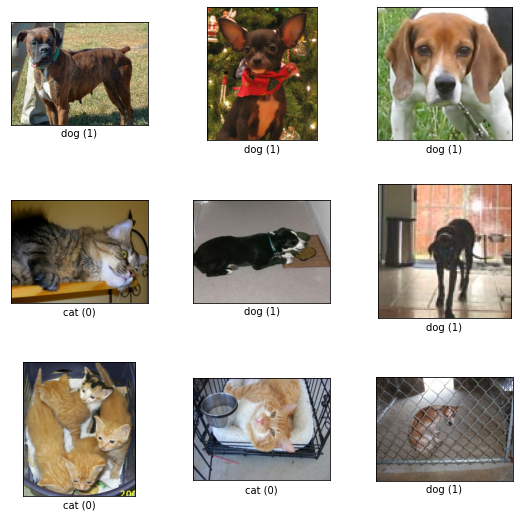

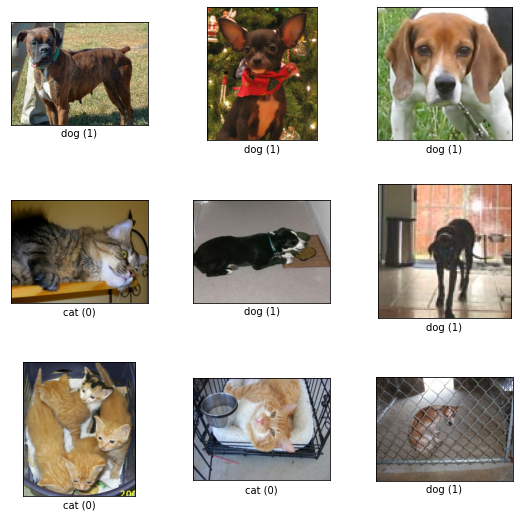

In [ ]:
tfds.show_examples(datos['train'], metadatos)  ## Mostramos ejemplos del set de datos con imagenes de perros y gatos junto con su etiqueta

In [ ]:
## Creación del diccionario en el cual guardaremos las imagenes procesadas con su etiqueta para el entrenamiento.

datos_entrenamiento = []

In [ ]:
## En esta parte realizamos el procesamiento de las imagenes las cuales deben ser modificadas 
## tanto en tamaño como sus colores para que la red las pueda procesar de mejor manera.

for i, (imagen, etiqueta) in enumerate(datos['train']):
  imagen = cv2.resize(imagen.numpy(), (100, 100))  # Cambio de tamaño
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY) # Modifiación de color
  imagen = imagen.reshape(100, 100, 1) # Guardamos la imagen con su tamaño y canal de color
  datos_entrenamiento.append([imagen, etiqueta])

In [ ]:
len(datos_entrenamiento) # Cantidad de datos en total

23262

In [ ]:
## Preparación de variables X (entradas) e y (etiquetas) separadas

X = [] #imagenes de entrada (pixeles)
y = [] #etiquetas (perro o gato)

for imagen, etiqueta in datos_entrenamiento:
  X.append(imagen)
  y.append(etiqueta)

In [ ]:
X[0] # Veamos el primer elemento nuestro arreglo en el set de imagenes en pixeles

array([[[242],
        [190],
        [105],
        ...,
        [189],
        [195],
        [143]],

       [[230],
        [130],
        [ 88],
        ...,
        [188],
        [179],
        [187]],

       [[170],
        [ 93],
        [ 84],
        ...,
        [131],
        [158],
        [168]],

       ...,

       [[112],
        [173],
        [164],
        ...,
        [141],
        [152],
        [119]],

       [[140],
        [151],
        [172],
        ...,
        [ 96],
        [150],
        [152]],

       [[ 92],
        [112],
        [168],
        ...,
        [ 44],
        [ 52],
        [ 47]]], dtype=uint8)

In [ ]:
y[0] # Veamos el primer elemento nuestro arreglo en el set de etiquetas

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [ ]:
# Normalizacón de los datos
X = np.array(X).astype(float) / 255
y = np.array(y)

In [ ]:
X.shape

(23262, 100, 100, 1)

In [ ]:
## Para generar el set de entrenamiento y validación debemos considerar del total de datos 80% para entrenamiento y 20% para el test.

round(len(X) * 0.80) # Tomamos el 80% de los datos que serían aproximadamente 18610 

18610

In [ ]:
len(X) - round(len(X) * 0.80) # El 20% restante

4652

In [ ]:
## Creación de los set de datos de entrenamiento y validación

X_entrenamiento = X[:18610]
X_validacion = X[18610:]

y_entrenamiento = y[:18610]
y_validacion = y[18610:]

In [ ]:
# Generación de transforamciones de imagenes para el aprendizaje convolucional de la red

datagen = ImageDataGenerator(
        featurewise_center = False,  # establecer la media de entrada en 0 sobre el conjunto de datos
        samplewise_center = False,  # establecer la media de cada muestra en 0
        featurewise_std_normalization = False,  # dividir inputs por std del dataset
        samplewise_std_normalization = False,  # dividir cada input por std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 30,  # rotación aleatoria de imagenes según rangos de 0 a 180 grados
        zoom_range = 0.2, # zoom o acercamiento aleatorio de imagen 
        width_shift_range=0.1,  # cambio aleatorio de las imágenes horizontalmente
        height_shift_range=0.1,  # cambio aleatorio de las imágenes verticalmente
        horizontal_flip = True,  # giro aleatorio de imagen
        vertical_flip = False)  # giro aleatorio de imagen


datagen.fit(X_entrenamiento)

In [ ]:
## Definición de capas en red neuronal

## Capa de entrada
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(100,100,1)))
model.add(MaxPool2D())

## Capas ocultas
model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

## Capa de salida
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

In [92]:
opt = Adam(learning_rate=0.000001)

model.compile(optimizer = opt, 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])

In [93]:
## Realizamos el entrenamiento de la red neuronal, 

epocas = 10
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(X_entrenamiento,
                    y_entrenamiento,
                    epochs = epocas,
                    validation_data = (X_validacion, y_validacion), callbacks=[es])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


582/582 [==============================] - 8s 13ms/step - loss: 0.4973 - accuracy: 0.7618 - val_loss: 0.5038 - val_accuracy: 0.7552
Epoch 2/10
582/582 [==============================] - 8s 13ms/step - loss: 0.4973 - accuracy: 0.7606 - val_loss: 0.5060 - val_accuracy: 0.7569
Epoch 3/10
582/582 [==============================] - 8s 14ms/step - loss: 0.4959 - accuracy: 0.7625 - val_loss: 0.5034 - val_accuracy: 0.7564
Epoch 4/10
582/582 [==============================] - 8s 13ms/step - loss: 0.4959 - accuracy: 0.7639 - val_loss: 0.5040 - val_accuracy: 0.7511
Epoch 5/10
582/582 [==============================] - 8s 13ms/step - loss: 0.4958 - accuracy: 0.7615 - val_loss: 0.5029 - val_accuracy: 0.7564
Epoch 6/10
582/582 [==============================] - 8s 13ms/step - loss: 0.4959 - accuracy: 0.7633 - val_loss: 0.5031 - val_accuracy: 0.7588
Epoch 7/10
582/582 [==============================] - 8s 14ms/step - loss: 0.4924 - accuracy: 0.7645 - val_loss: 0.5026 - val_accuracy: 0.7577
Epoch 8/10

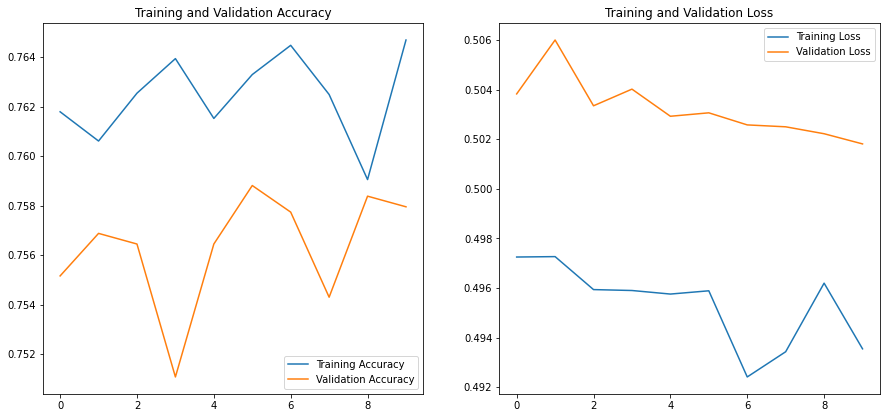

In [95]:
## Revisamos utilizando gráficos el desempeño del modelo y su pérdida.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [96]:
## Veamos como nos va con la red neuronal, para eso desplegamos las métricas del modelo.

predict_x=model.predict(X_validacion)
classes_x=np.argmax(predict_x,axis=1)
print(classification_report(y_validacion, classes_x, target_names = ['cats (Class 0)','dog (Class 1)']))

                precision    recall  f1-score   support

cats (Class 0)       0.75      0.78      0.76      2344
 dog (Class 1)       0.77      0.74      0.75      2308

      accuracy                           0.76      4652
     macro avg       0.76      0.76      0.76      4652
  weighted avg       0.76      0.76      0.76      4652



In [ ]:
## Guardar modelo

#model.save('perros-gatos.h5')

In [ ]:
modelo = tf.keras.models.load_model('perros-gatos.h5')

In [ ]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

**Modelo entrenado con 300 epocas**

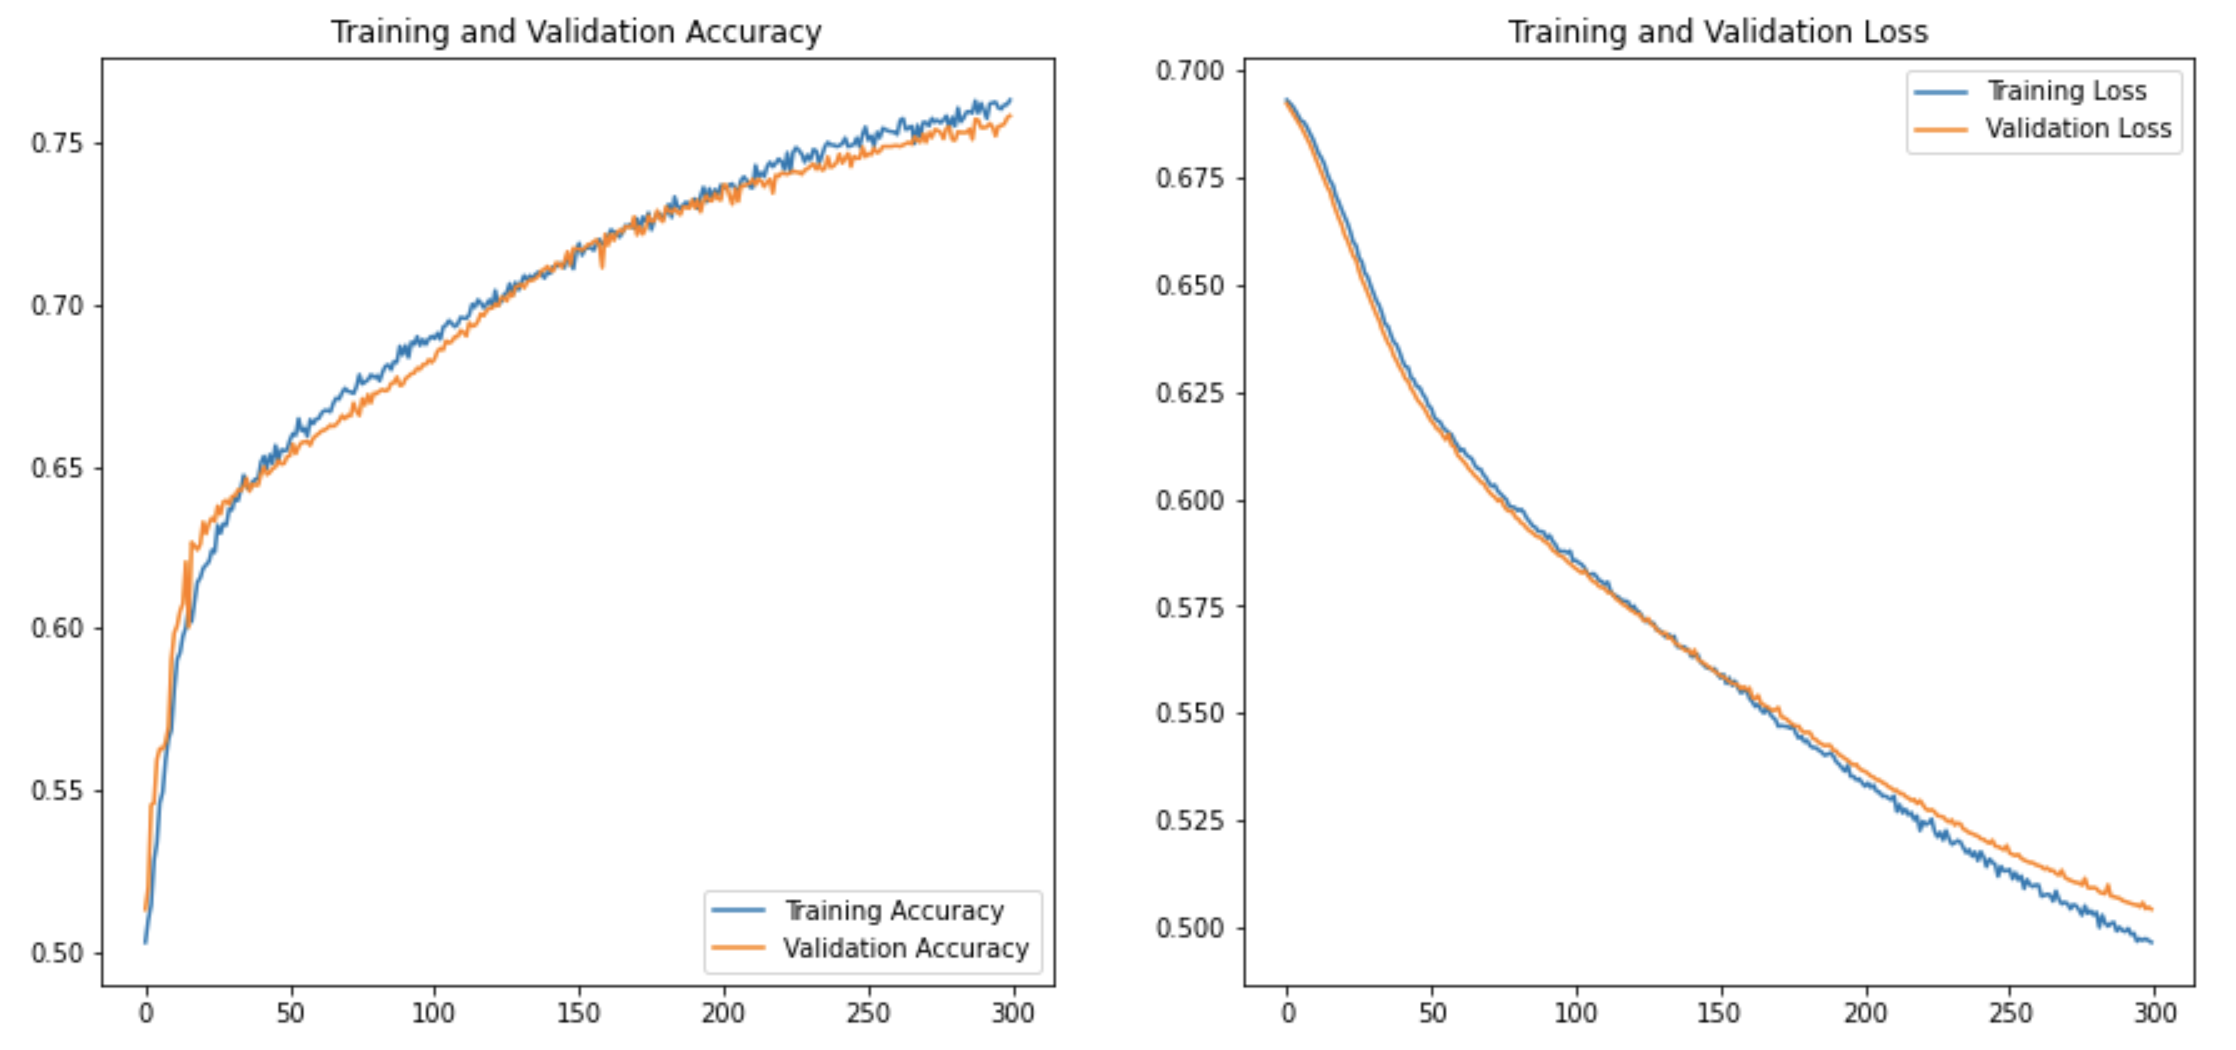

In [91]:
img = cv2.cvtColor(io.imread("https://raw.githubusercontent.com/yerkogallardo/perros_gatos_CNN/b20452c46711b74fdd0610425f2cccef456d3408/300_epoch.png"), cv2.COLOR_BGR2RGB)
cv2_imshow(img)

In [ ]:
## Revisamos las métricas

predict_new = modelo.predict(X_validacion)
classes_new = np.argmax(predict_new,axis=1)
print(classification_report(y_validacion, classes_new, target_names = ['cats (Class 0)','dog (Class 1)']))

                precision    recall  f1-score   support

cats (Class 0)       0.76      0.77      0.76      2344
 dog (Class 1)       0.76      0.75      0.75      2308

      accuracy                           0.76      4652
     macro avg       0.76      0.76      0.76      4652
  weighted avg       0.76      0.76      0.76      4652



In [ ]:
from google.colab.patches import cv2_imshow ## Agregamos esta librería para procesar imagenes de predicción.

In [89]:
## Creamos una función para realizar predicciones

def clasificador(imagen):
  # Obtiene la imagen y la transforma para mostrarla junto con su resultado.
  img_source = cv2.imread(imagen)
  img_source = cv2.resize(img_source,(224, 224))
  cv2_imshow(img_source)

  # Procesamiento de imagen para evaluar en el modelo.
  imagen = cv2.imread(imagen)
  imagen = cv2.resize(imagen, (100, 100))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  imagen = imagen.reshape(1, 100, 100, 1)

  # Realización de la predicción.
  pred_mod = modelo.predict(imagen) 

  # En esta parte realizamos el tratamiento del resultado del modelo.
  classes_x=np.argmax(pred_mod,axis=1)
  pred_val = (modelo.predict(imagen) > 0.5).astype("int32")
  
  if classes_x == 0:
    pred_class ='Gato 😺'
  else:
    pred_class ='Perro 🐶'

  # Entrega de resultados.
  print(pred_mod)
  print(pred_val)
  print(pred_class)

## Ahora vamos a hacer pruebas

In [ ]:
## Importamos librerias para hacer las pruebas

from google.colab import files
from IPython. display import Image

Saving 7.jpg to 7.jpg


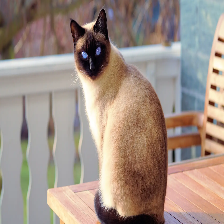

[[9.9999893e-01 1.0655891e-06]]
[[1 0]]
Gato 😺


In [101]:
uploaded = files.upload()
nombre_archivo = next(iter(uploaded))
clasificador(nombre_archivo)

Saving 5.jpeg to 5.jpeg


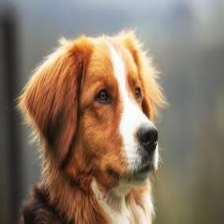

[[0. 1.]]
[[0 1]]
Perro 🐶


In [90]:
uploaded = files.upload()
nombre_archivo = next(iter(uploaded))
clasificador(nombre_archivo)